<a href="https://colab.research.google.com/github/shekhar-hazari/CML-Assignment-2/blob/main/Luke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
In this task a cancer cell detection system will be created.

Luke Mason - s3630120 \
Shekhar Hazari - s3831855

# 0 - Setup

## 0.1 - Import packages

In [194]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 0.2 - Initialise helper functions¶

In [195]:
def holdout_validation(train_size, X, Y):
    """
    Splits the data sets for hold out validation across the whole dataset given.

    :param train_size: The size of the trianing set.
    :param X: The X columns
    :param Y: The target column
    :return: the train, validation, test sets for both X columns and Y columns.
    """

    # Get the difference between train and test size, together both make 100% of the raw data set.
    test_size = 1 - train_size

    # Split into train and test for normal and target fields set, left overs are for validation and test.
    with pd.option_context('mode.chained_assignment', None):
        train_X, X_test_, train_Y, Y_test_ = train_test_split(X, Y, test_size=test_size, shuffle=True, random_state=0)

    # Split the test data into validation test and test.
    # Do for target field and normal fields.
    with pd.option_context('mode.chained_assignment', None):
        val_X, test_X, val_Y, test_Y = train_test_split(X_test_, Y_test_, test_size=0.5, shuffle=True, random_state=29)
    return train_X, val_X, test_X, train_Y, val_Y, test_Y

In [196]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3,
              hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows, ncols, index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)

    plt.title(title)
    plt.xticks(rotation='vertical')

In [197]:
def train_val_test_split_by_column(dataframe, column, seed, train_size=0.666, val_size=0.5):
    """
    Creates the train, validation and test sets based on a column.
    :param dataframe:  The dataframe that holds the data.
    :param column:     The column to do the splitting on.
    :param seed:       The seed for the randomizer splitter.
    :param train_size: The size of the training set.
    :param val_size:   The size of the validation set, with the left overs being the test set.
    :return: The train, validation and test sets.
    """

    # Getting the unique column values to split on so that no same values are in different sets.
    splitting_IDs = dataframe[column].unique()

    # Split the train set from the rest.
    train_IDs, test_IDs = train_test_split(splitting_IDs, train_size=train_size, shuffle=True, random_state=seed)

    # Split the left over into the validation and test sets.
    val_IDs, test_IDs = train_test_split(test_IDs, train_size=val_size, shuffle=True, random_state=seed)

    # Turn into dataframe.
    train_IDs = pd.DataFrame(train_IDs)

    # Create column split with values being train. This lets us distinguish the
    # training data from the other data sets when we merge them all together.
    train_IDs.rename(columns={0: column}, inplace=True)
    train_IDs['split'] = 'train'

    # Turn into dataframe.
    val_IDs = pd.DataFrame(val_IDs)

    # Create column split with values being validation. This lets us distinguish the
    # validation data from the other data sets when we merge them all together.
    val_IDs.rename(columns={0: column}, inplace=True)
    val_IDs['split'] = 'validation'

    # Turn into dataframe.
    test_IDs = pd.DataFrame(test_IDs)

    # Create column split with values being test. This lets us distinguish the
    # test data from the other data sets when we merge them all together.
    test_IDs.rename(columns={0: column}, inplace=True)
    test_IDs['split'] = 'test'

    # Combine the split ids
    splits = pd.concat([train_IDs, val_IDs, test_IDs], ignore_index=True)

    # Add the new columns to original dataframe.
    dataframe = pd.merge(dataframe, splits, on=column)

    # Extract the training set where split equals train.
    train_set = dataframe[dataframe['split'] == 'train']
    train_set = train_set.drop(['split'], axis=1)

    # Extract the validation set where split equals validation.
    validation_set = dataframe[dataframe['split'] == 'validation']
    validation_set = validation_set.drop(['split'], axis=1)

    # Extract the test set where split equals test.
    test_set = dataframe[dataframe['split'] == 'test']
    test_set = test_set.drop(['split'], axis=1)

    return train_set, validation_set, test_set

In [198]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric,
                        metric_name='Accuracy'):
    """
    Plots the history returned by model.fit().
    :param train_loss: The loss history from fitting.
    :param val_loss: The validation set loss history from validating.
    :param train_metric: The training metrics.
    :param val_metric: The validation metrics.
    :param metric_name: The metric name i.e accuracy
    :return: A graph plotting the history of the training and fitting results after every epoch.
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [199]:
def get_imagery_data_sets(train_set, validation_set, test_set, directory, x_col, y_col, batch_size):
    """
    Gets the imagery data from the reference id's in each data set.
    :param train_set: The dataframe containing the set of ids in the training set.
    :param validation_set: The dataframe containing the set of validation ids.
    :param test_set: The dataframe containing the test ids.
    :param directory: The directory that the images are located.
    :param y_col: The target column name to make the taget column into a string type.
    :param batch_size: The batch size to which the data generator batches the imagery data.
    :return: Returns the 3 data generators (train, validation, test) that have the images data.
    """
    # Make target feature a string so that the categorical class_mode can categorise it.
    train_set[y_col] = train_set[y_col].astype('str')
    validation_set[y_col] = validation_set[y_col].astype('str')
    test_set[y_col] = test_set[y_col].astype('str')

    train_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
    val_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
    test_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')

    # The parameters that all data set generators have in common.
    generator_parameters = dict(
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=(27, 27),
        class_mode='categorical')

    # Train set generator to evaluate produce dataframe with train images.
    train_imagery_set = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        batch_size=batch_size,
        **generator_parameters)

    # Validation set generator to evaluate produce dataframe with validation images.
    val_imagery_set = val_datagen.flow_from_dataframe(
        dataframe=validation_set,
        batch_size=batch_size,
        **generator_parameters)

    # Test set generator to evaluate produce dataframe with test images.
    test_imagery_set = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        batch_size=1,
        **generator_parameters)

    return train_imagery_set, val_imagery_set, test_imagery_set

In [200]:
def get_unique_id_from_hyperparameters(hyperparameters, model_name):
    """
    Creates a unique id from a dictionary of hyperparameters and names from layers, that is used in naming a model uniquely.
    :param hyperparameters: The dictionary of hyperparameters for a model.
    :param model_name: The name of the model.
    :return: A unique name that was from encoding the hyperparameters and getting the names of the layers.
    """
    name = []

    # join the parameters into a name.
    for key in hyperparameters:
        first_letter = key[0].capitalize()
        value = hyperparameters[key].name if not isinstance(hyperparameters[key], str) and not isinstance(
            hyperparameters[key], int) else hyperparameters[key]
        name.append(first_letter + str(value).replace("_", ""))

    name.append(model_name)
    return "_".join(name)

In [201]:
def setup_model_store(hyperparameters, model_name):
    """
    Sets up the paths and directories necessary to save the model and training history of that model.
    :param hyperparameters: The hyperparameters of the model.
    :param model_name: The name of the model.
    :return: The full path of the model directory and the full path location for the history.
    """
    # Train MLP.
    model_id = get_unique_id_from_hyperparameters(hyperparameters, model_name)
    print("~~~~~~~~~~ " + model_id + " ~~~~~~~~~~")

    # Root google dir.
    root_dir = "/content/drive/My Drive/CML-Assignment-2/"

    # Make path for models.
    model_dir = "models/" + model_id
    full_model_dir = root_dir + model_dir

    # Make path for history logs.
    history_path = model_dir + "/history.csv"
    full_history_path = root_dir + history_path

    # Make a directory if it doesn't exist. Any error output do not show.
    !mkdir / content / drive / 'My Drive' / CML-Assignment-2 / {model_dir} 2 > / dev / null

    return full_model_dir, full_history_path

In [202]:
def diff(count, highest_value):
  return abs(((count/highest_value) * 100) - 100)

In [203]:
def get_variance_between_datasets(main_train_set, main_validation_set, main_test_set, optimise_column):

  # Initialise varaince to 0.
  total_variance = 0

  # Loop through the different cell types.
  for i in range(0, len(main_train_set.groupby(optimise_column).count()['ImageName'])):

    # Get the frequency count for each cell type
    train_count = main_train_set.groupby(optimise_column).count()['ImageName'][i]
    val_count = main_validation_set.groupby(optimise_column).count()['ImageName'][i]
    test_count = main_test_set.groupby(optimise_column).count()['ImageName'][i]

    # Get the highest frequency count.
    highest_value = max(train_count, val_count, test_count)

    # Get the total difference in how much the data sets differ from the highest value.
    # Best case scenario is that they are all equal and difference = 0.
    total_variance += diff(train_count, highest_value) + diff(val_count, highest_value) + diff(test_count, highest_value)
  
  return total_variance


In [204]:
def optimise_split(data_set, split_column, optimise_column, iterations):
  seed = 0
  smallest_variance = 9999
  for i in range(1, iterations):
    # Split the data based on patient ID.
    main_train_set, main_validation_set, main_test_set = train_val_test_split_by_column(data_set, split_column, i)
    variance = get_variance_between_datasets(main_train_set, main_validation_set, main_test_set, optimise_column)
    if variance < smallest_variance:
      smallest_variance = variance
      seed = i

  return seed, smallest_variance

In [205]:
def run_model(model, parameters, model_name, model_func):
    # Setup the directories and paths for saving and loading the model and history.
    model_dir, history_path = setup_model_store(parameters, model_name)

    try:
        # Load a model that exists.
        model = tf.keras.models.load_model(model_dir)

        # Print summary.
        model.summary()

        # Read in the history chart from fitting the model previously.
        history = pd.read_csv(history_path, delimiter=',')
    except:
        # Print summary.
        model.summary()

        # Run model and get history.
        history = model_func()
     
        # Save Model.
        model.save(model_dir)

        # Save history.
        pd.DataFrame.from_dict(history).to_csv(history_path, index=False)

    return history

In [206]:
def train_save(train_set, val_set, test_set, hyper_parameters, model, y_label):
    # Extract the imagery into new data sets from the original data sets that
    # contained the image references.
    train_imagery_set, val_imagery_set, test_imagery_set = get_imagery_data_sets(
        train_set, val_set, test_set, './patch_images/', 'ImageName',
        y_label, hyper_parameters["batch_size"])

    # Compile the model with the hyper parameters chosen.
    model.compile(optimizer=hyper_parameters["optimizer"],
                  loss=hyper_parameters["loss"],
                  metrics=hyper_parameters["metrics"])

    # Fit the model with the generators, and epoch amount.
    history = model.fit(train_imagery_set, validation_data=val_imagery_set,
                        epochs=hyper_parameters["epochs"], verbose=0).history

    return history


## 0.3 - Unzip zipped data

In [207]:
from google.colab import drive

# Mount the google drive to get the imagery data and get any saved models previously.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [208]:
# Change according to your directory structure
!cp /content/drive/'My Drive'/CML-Assignment-2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


## 0.4 - Load the data
This data contains both the cell type and isCancerous labels.

In [209]:
# Load the csv data, which contains references to the imagery data.
ct_data = pd.read_csv('./data_labels_mainData.csv', delimiter=',')
extra_data = pd.read_csv('./data_labels_extraData.csv', delimiter=',')

# 1 - Exploratory Data Analysis
This section is an analysis on the main data set.
This will be used to classify the cell types correctly.

Next is an analysis on the extra data and how that can be combined with the main data to improve the accuracy of the models in determining if the cell picture is cancerous or not.

## 1.1 Main Data Set EDA

In [210]:
ct_data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [211]:
ct_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [212]:
ct_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


### 1.1.1 - Splitting the Main Data
Splitting the main dataset into train, validation and test sets.
This section actually split the data based on patient, so the data associated with that patient is not split across multiple data sets but instead all would be in one of the data sets, train, validation or test.

This is done so that the test and validation data is tested on training data that came from completely new patients. If the patient's data was split across all the datasets then the data in the training set could be used to classify the same patients cells in the validation and test set. This would cause a problem if the model is used to classify new patients on a different data set. This decision allows for bias to be detected during training of the model and testing and counter measures can be put in place to reduce this seen bias.

Split on many seeds to try find the optimal seed that produces the least variance of the data over the data sets so that all cell types are evenly distributed over the data sets.

In [213]:
seed, smallest_variance = optimise_split(ct_data, 'patientID', 'cellTypeName', 300)

print("Best seed: " + str(seed))
print("Smallest Accumulated Variance %: " + str(smallest_variance))

Best seed: 226
Smallest Accumulated Variance %: 457.1016654051119


Get the final judgment for the chosen seed to perform the split onto. (Seed 226)

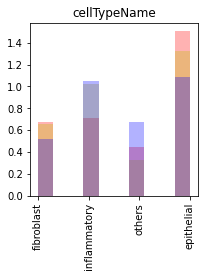

In [214]:
# Split on the ultimate seed split with the least variance over the patient data.
train_set_ct, validation_set_ct, test_set_ct = train_val_test_split_by_column(ct_data, 'patientID', seed)

# Graph the split results.
plt.figure(figsize=(3, 3))
col = "cellTypeName"
hist_plot(col, [train_set_ct[col], validation_set_ct[col], test_set_ct[col]], ['r', 'y', 'b'], 1, 1, 1)

🧐 **Observations:**
> - Epithelial cell type is evenly distributed over the train, validation and test set, but the other types are not.
> - Train set has the epithelial data, test set has the least.
> - Fibroblast is relatively the same over the 3 data sets.
> - Train set lacks in the inflammatory data comapred to the other data sets.
> - Validation data contains half other cell types than the test set
> - The data has been split to optimise on cell type which means isCancerous target might be badly variant and un even.

👨🏻‍🎓 **Conclusions**
> - Splitting on patient ID can't get all colours to be overlapped meaning that some patients have more data than others which means applying patients to entire datasets can't even distribute the total data eveny well.
> - Test if this data split is also opitmised for isCancerious target field.

Test if this data split is also opitmised for isCancerious target field.

In [215]:
print('Overall ferquency of isCancerous:')
print(ct_data.isCancerous.value_counts().to_frame())

print('In training data: ')
print(train_set_ct.isCancerous.value_counts().to_frame())

print('In validation data: ')
print(validation_set_ct.isCancerous.value_counts().to_frame())

print('In test data: ')
print(test_set_ct.isCancerous.value_counts().to_frame())

Overall ferquency of isCancerous:
   isCancerous
0         5817
1         4079
In training data: 
   isCancerous
0         3004
1         2479
In validation data: 
   isCancerous
0         1343
1          888
In test data: 
   isCancerous
0         1470
1          712


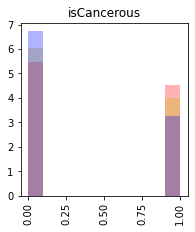

In [216]:
# Graph the split results.
plt.figure(figsize=(3, 3))
col = "isCancerous"
hist_plot(col, [train_set_ct[col], validation_set_ct[col], test_set_ct[col]], ['r', 'y', 'b'], 1, 1, 1)

🧐 **Observations:**
> - In the main data set there approx 30% less cancerous (1) cell data than non-cancerous (0).
> - After the split, train set has approx 20% less cancerous (1) cell data than non-cancerous (0).
> - After the split, validation set has approx 60% less cancerous (1) cell data than non-cancerous (0).
> - After the split, test set has approx 50% less cancerous (1) cell data than non-cancerous (0).

👨🏻‍🎓 **Conclusions**
> - Splitting in priority of cell type has made the diffence in cancerous and non-cancerous variance very high, with some data sets contianing 50% difference in cancerous to non-cancerous.
> - Optimise the data split again for cancerous and non cancerous classification.

### 1.1.2 - Preview Main Data
Previewing the contents of the main data set.

In [217]:
df1 = ct_data.groupby(['cellTypeName', 'cellType'])['InstanceID'].nunique()
df2 = ct_data.groupby(['isCancerous'])['InstanceID'].nunique()
print(df1)
print(df2)

cellTypeName  cellType
epithelial    2           4079
fibroblast    0           1888
inflammatory  1           2543
others        3           1386
Name: InstanceID, dtype: int64
isCancerous
0    5817
1    4079
Name: InstanceID, dtype: int64


In [218]:
label_names = {k: v for k, v in df1.keys()}
cellTypes = {v: k for k, v in label_names.items()}
print(label_names)
print(cellTypes)

{'epithelial': 2, 'fibroblast': 0, 'inflammatory': 1, 'others': 3}
{2: 'epithelial', 0: 'fibroblast', 1: 'inflammatory', 3: 'others'}


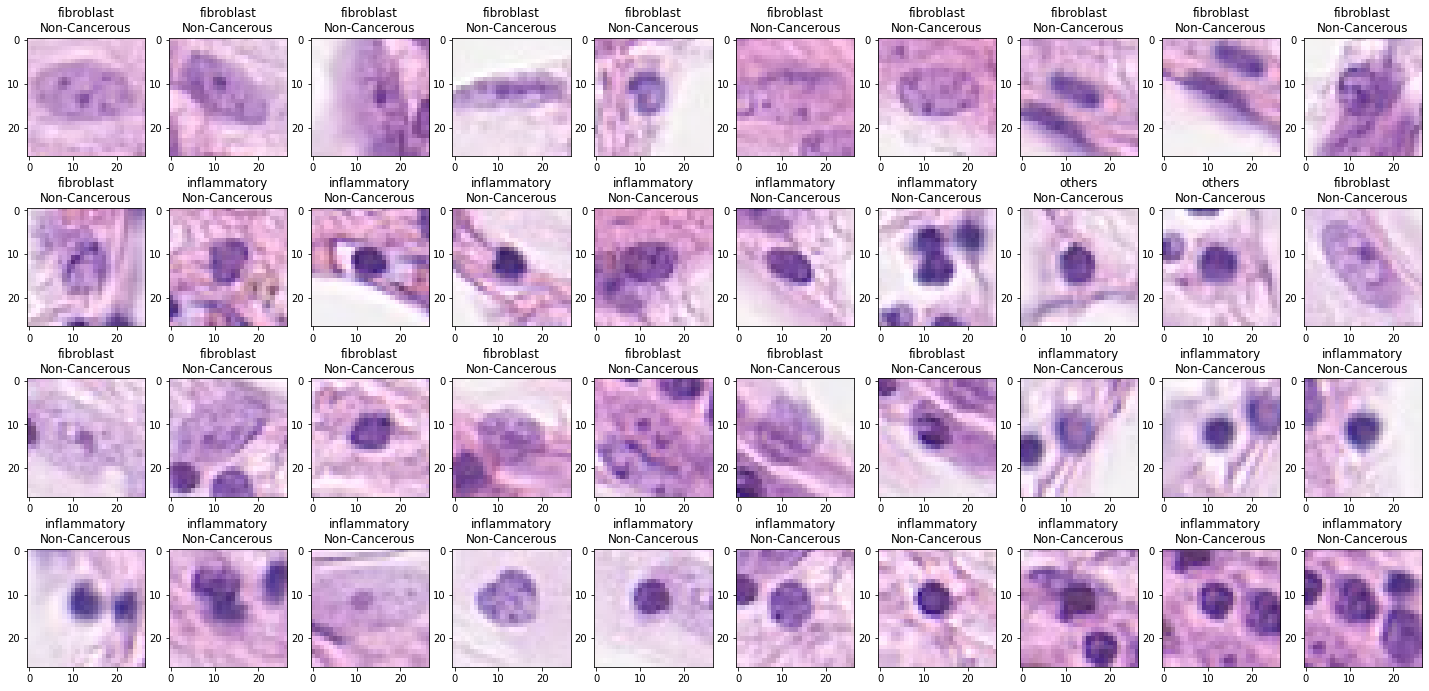

In [219]:
img_list = list(ct_data["ImageName"])
types = list(ct_data["cellType"])
target_list = list(ct_data["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25, 12])

for i in np.arange(40):
    plt.subplot(4, 10, i + 1)
    img = Image.open('./patch_images/' + img_list[i])

    plt.imshow(img)
    plt.title(cellTypes[types[i]] + "\n" + target_labels[target_list[i]])

In [220]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size: 
H:27 W:27 C:3


### 1.1.3 - Transform Main Data
Set all types to be of type Object. We do this because all the variables are categorical, they don't have any continuous values, so it's easier while creating visualizations.

In [221]:
for column in ct_data.columns:
    ct_data[column] = ct_data[column].astype('object')

In [222]:
print(ct_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   object
 1   patientID     9896 non-null   object
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   object
 5   isCancerous   9896 non-null   object
dtypes: object(6)
memory usage: 464.0+ KB
None


### 1.1.4 - Examine Main Data
Examining the data's distribution via bucketing the categories.



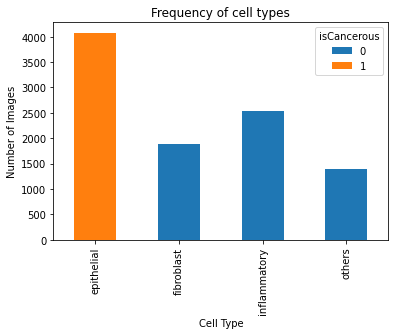

In [223]:
pd.crosstab(ct_data['cellTypeName'], ct_data['isCancerous'], margins=False).plot.bar(stacked=True,
                                                                                         title='Frequency of cell types',
                                                                                         xlabel='Cell Type',
                                                                                         ylabel='Number of Images')

🧐 **Observations:**
> - All epithelial cell types are cancerous in this dataset.
> - All the rest of the cell types are not cancerous
> - There is a lot more epithelial cells compared to the other types.

👨🏻‍🎓 **Conclusions**
> - Epithelial cells are biased to only being cancerous when in fact all humans have epithelial cells in our bodies and some humans don't have cancer, so if there are epithelial cells in the test set that are not cancerous then the system could be biased in thinking they are.
> - This same logic appleis the other way with the rest of the cell types all not being cancerous. If the other cell types become cancerous then it is **possible** the system is biased towards them never being cancerous.

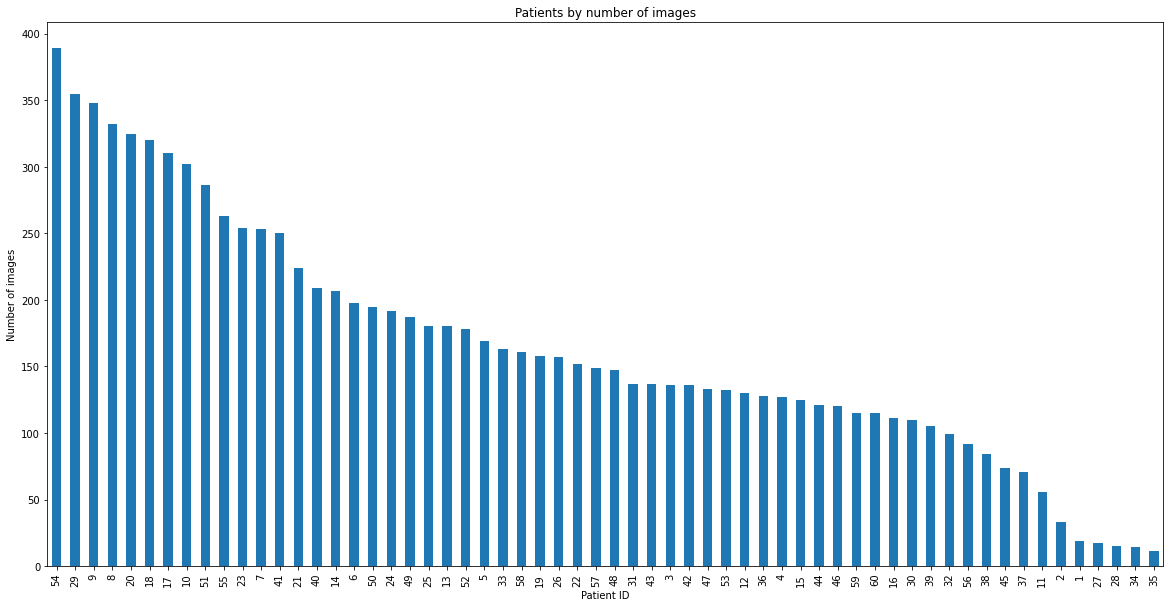

In [224]:
ct_data.patientID.value_counts().to_frame().plot(kind='bar',
                                                    title='Patients by number of images',
                                                    xlabel='Patient ID', ylabel='Number of images',
                                                    legend=False,
                                                   figsize=[20,10])

🧐 **Observations:**
> - The top 5 patients contain between 330 - 380 images
> - Bottom 5 patients contain 

👨🏻‍🎓 **Conclusions**
> - 

## 1.2 Combined Data Set EDA

In [225]:
ct_data.describe()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
count,9896,9896,9896,9896,9896,9896
unique,9896,60,9896,4,4,2
top,972,54,16719.png,epithelial,2,0
freq,1,389,1,4079,4079,5817


In [226]:
ct_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [227]:
ct_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   object
 1   patientID     9896 non-null   object
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   object
 5   isCancerous   9896 non-null   object
dtypes: object(6)
memory usage: 464.0+ KB


### 1.2.1 Combining main and extra data

In [228]:
# Remove the cellType and cellTypeName columns
trimmed_1 = ct_data.drop(['InstanceID', 'cellTypeName', 'cellType'], axis=1)
trimmed_2 = extra_data.drop(['InstanceID'], axis=1)
comparison = trimmed_1.columns == trimmed_2.columns
assert comparison.all()

# Combine datasets
ic_data = pd.concat([trimmed_1, trimmed_2])

# Set ImageName column as indexed column
ic_data.set_index('ImageName')

,patientID,isCancerous
ImageName,,
22405.png,1,0
22406.png,1,0
22407.png,1,0
22408.png,1,0
22409.png,1,0
...,...,...
20028.png,99,0
20029.png,99,0
20030.png,99,0


### 1.2.2 - Splitting the Combined Data

Split on many seeds to try find the optimal seed that produces the least variance of the data over the data sets so that all data for 'isCancerous' are evenly distributed over the data sets.

In [229]:
seed, smallest_variance = optimise_split(ic_data, 'patientID', 'isCancerous', 300)

print("Best seed: " + str(seed))
print("Smallest Accumulated Variance %: " + str(smallest_variance))

Best seed: 12
Smallest Accumulated Variance %: 241.00443520460635


Get the final judgment for the chosen seed to perform the split onto. (Seed 232)

12


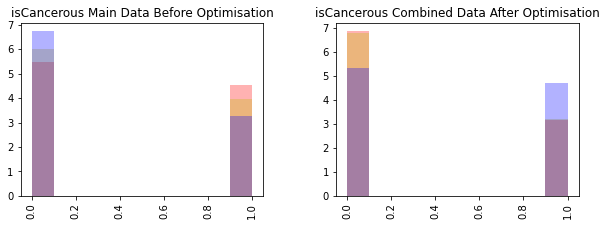

In [230]:
print(seed)

# Split on the ultimate seed split with the least variance over the patient data.
train_set_ic, validation_set_ic, test_set_ic = train_val_test_split_by_column(ic_data, 'patientID', seed)

# Graph the split results.
plt.figure(figsize=(10, 3))
col = "isCancerous"
hist_plot("isCancerous Main Data Before Optimisation", [train_set_ct[col], validation_set_ct[col], test_set_ct[col]], ['r', 'y', 'b'], 1, 2, 1)
hist_plot("isCancerous Combined Data After Optimisation", [train_set_ic[col], validation_set_ic[col], test_set_ic[col]], ['r', 'y', 'b'], 1, 2, 2)

🧐 **Observations:**
> - The test and validation sets have almost not variance between them (they are stacked identically.
> - The test data is almsot the same hight in bar height
> - overall there is more non-cancerous data from cancerous data still after combination.

👨🏻‍🎓 **Conclusions**
> - Get the numerical differences

Finding the numerical differences in the data\
1 = cancerous
0 = non-cancerous

In [231]:
print('Overall ferquency of isCancerous:')
print(ic_data.isCancerous.value_counts().to_frame())

print('In training data: ')
print(train_set_ic.isCancerous.value_counts().to_frame())

print('In validation data: ')
print(validation_set_ic.isCancerous.value_counts().to_frame())

print('In test data: ')
print(test_set_ic.isCancerous.value_counts().to_frame())

Overall ferquency of isCancerous:
   isCancerous
0        13211
1         7069
In training data: 
   isCancerous
0         7968
1         3659
In validation data: 
   isCancerous
0         2977
1         1408
In test data: 
   isCancerous
0         2266
1         2002


🧐 **Observations:**
> - The combined dataset contains almost double the non-cancerous images than cancerous images.
> - The training set and validation set also contains more than double non-cancerous images than cancerous images.
> - The test set has almost an equal amount of cancerous vs non-cancerous images. This is really good for an idea accuracy test, and precision test, since if the model is biased towards non-cancerous then this test set will pick that up.

👨🏻‍🎓 **Conclusions**
> - Train and validation might perform really well in low variance but have a bias problem towards non-cancerous results.

### 1.2.3 - Preview Combined Data
Previewing the contents of the main data set.

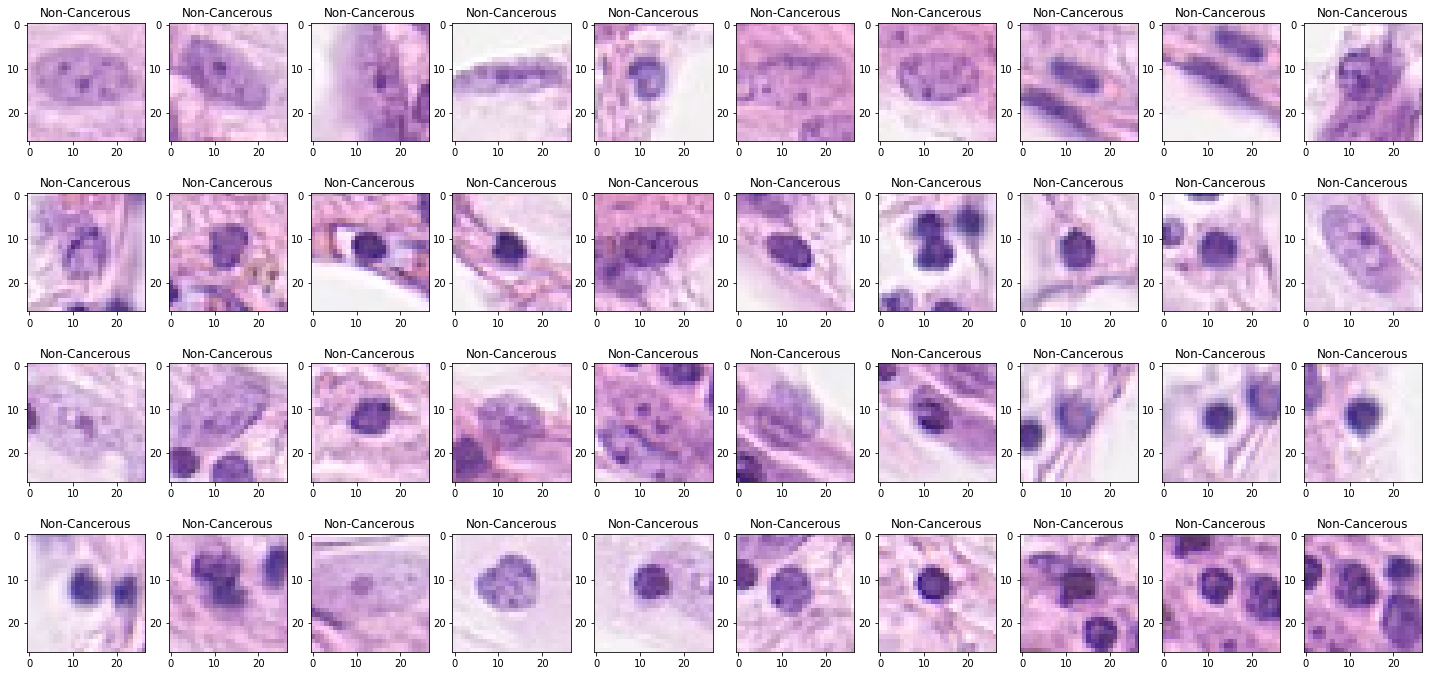

In [232]:
img_list = list(train_set_ic["ImageName"])
target_list = list(train_set_ic["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25, 12])

for i in np.arange(40):
    plt.subplot(4, 10, i + 1)
    img = Image.open('./patch_images/' + img_list[i])

    plt.imshow(img)
    plt.title(target_labels[target_list[i]])

In [233]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size: 
H:27 W:27 C:3


### 1.2.4 - Transform Combined Data
Set all types to be of type Object. We do this because all the variables are categorical, they don't have any continuous values, so it's easier while creating visualizations.

In [234]:
for column in ic_data.columns:
    ic_data[column] = ic_data[column].astype('object')

In [235]:
print(ic_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   patientID    20280 non-null  object
 1   ImageName    20280 non-null  object
 2   isCancerous  20280 non-null  object
dtypes: object(3)
memory usage: 633.8+ KB
None


### 1.2.5 - Examine Combined Data

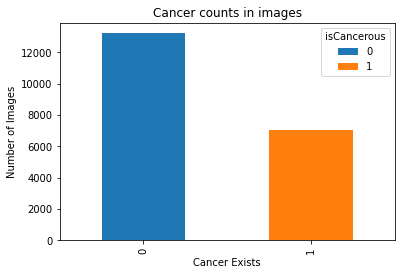

In [236]:
pd.crosstab(ic_data['isCancerous'], ic_data['isCancerous'], margins=False).plot.bar(stacked=True,
                                                                                    title='Cancer counts in images',
                                                                                    xlabel='Cancer Exists',
                                                                                    ylabel='Number of Images')

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

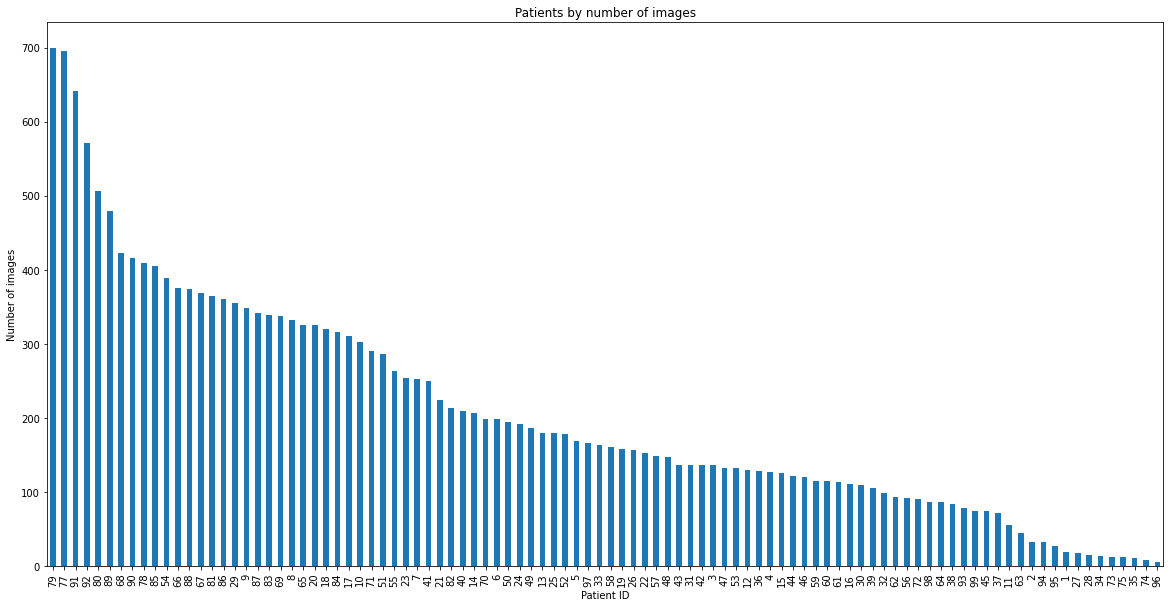

In [237]:
ic_data.patientID.value_counts().to_frame().plot(kind='bar',
                                                    title='Patients by number of images',
                                                    xlabel='Patient ID', ylabel='Number of images',
                                                    legend=False,
                                                   figsize=[20,10])

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

# 2 - Feature Selection

# 3 - Modelling 

In [238]:
# Initialise Constants
INPUT_DIM = (27, 27, 3)
OUTPUT_CLASSES = 2

## 3.1 Cancerous Classification
Checking if the image is cancerous or not cancerous

### 3.1.1 - MLP

Initialise Hyper Parameters and initial model layers

Hidden layer dimension is randomly set to a value that is 2^n to align with the computer's memory buffer. This is a starting point to iterate on.\
`hidden_layer_dim = 56`

TODO \
`optimizer = adam`

TODO \
`loss = CategoricalCrossentropy`

TODO \
`metrics = 'categorical_accuracy'`

TODO \
`epochs = 50`

TODO \
`batch_size = 32`

In [239]:
# hyperparameters.
parameters = {
    "hidden_layer_dim": 256,
    "optimizer": 'adam',
    "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    "metrics": 'categorical_accuracy',
    "epochs": 125,
    "batch_size": 32
}

#### Model 1

This model shows starts off with the input layer being the imagery with 3 colour bands, red, green, and blue.\
Then the images are flattened into a 1 dimensional array, [R,G,B] and passed into a single dense layer layer which ..........

~~~~~~~~~~ H256_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_MLP_1_CT ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_32 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_84 (Dense)             (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


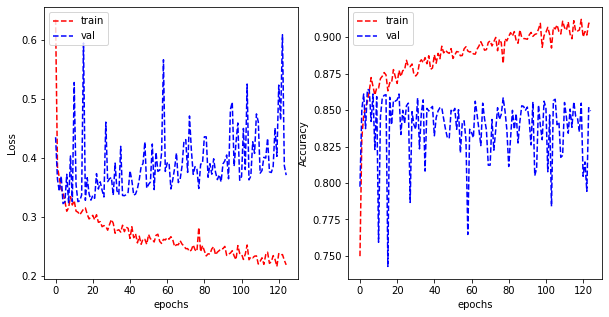

In [240]:
# The Deep Neural Network Layer Structure.
layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "MLP_1_CT",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 2
Dense has 128 percipatrons

~~~~~~~~~~ H128_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_MLP_2 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               280064    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 280,322
Trainable params: 280,322
Non-trainable params: 0
_________________________________________________________________


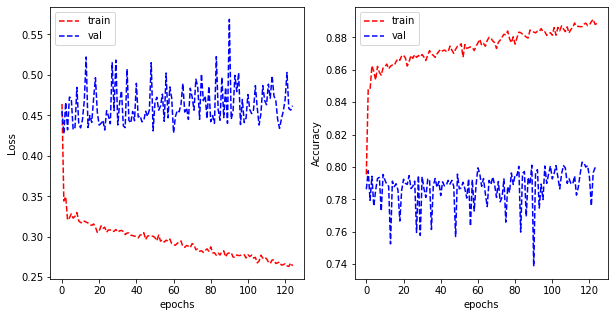

In [241]:
parameters["hidden_layer_dim"] = 128

# The Deep Neural Network Layer Structure.
layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "MLP_2_CT",
                    lambda: train_save(train_set_ic, validation_set_ic, test_set_ic, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 3
Dense has 64 percipatrons

~~~~~~~~~~ H64_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_MLP_3 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                140032    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 140,162
Trainable params: 140,162
Non-trainable params: 0
_________________________________________________________________


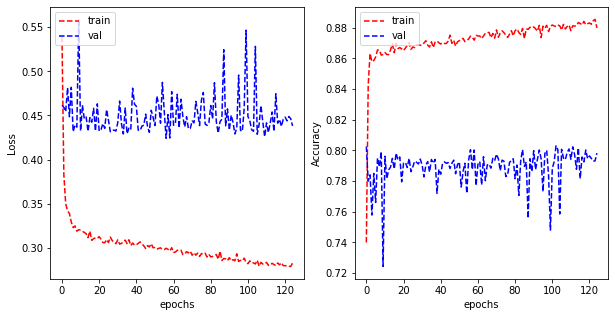

In [242]:
parameters["hidden_layer_dim"] = 64

# The Deep Neural Network Layer Structure.
layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "MLP_3_CT",
                    lambda: train_save(train_set_ic, validation_set_ic, test_set_ic, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 4
Adding dropout

~~~~~~~~~~ H64_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_MLP_4 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                140032    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 140,162
Trainable params: 140,162
Non-trainable params: 0
_________________________________________________________________


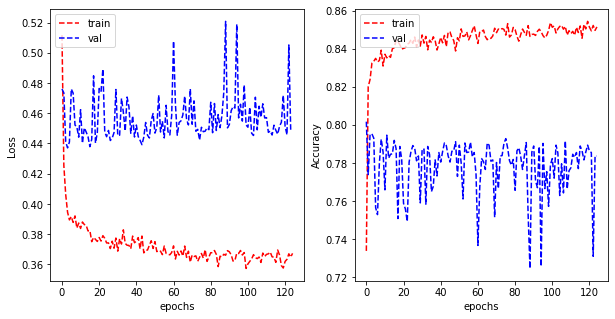

In [243]:
parameters["hidden_layer_dim"] = 64

# Added Dropout to the layers
layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "MLP_4_CT",
                    lambda: train_save(train_set_ic, validation_set_ic, test_set_ic, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 5
Dense has 128 percipatrons with dropout

~~~~~~~~~~ H128_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_MLP_5 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               280064    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 280,322
Trainable params: 280,322
Non-trainable params: 0
_________________________________________________________________


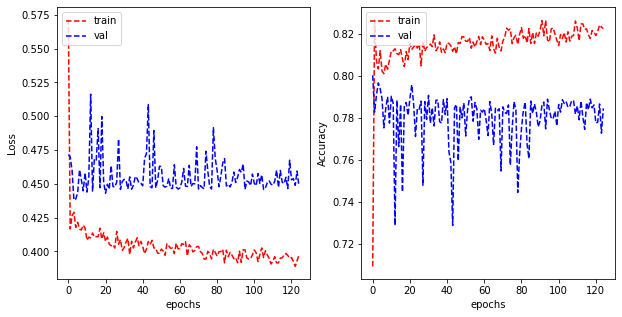

In [244]:
parameters["hidden_layer_dim"] = 128

layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "MLP_5_CT",
                    lambda: train_save(train_set_ic, validation_set_ic, test_set_ic, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 6
2 Layers instead of 1

~~~~~~~~~~ H256_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_MLP_6 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 576,706
Trainable params: 576,706
Non-trainable params: 0
_________________________________________________________________


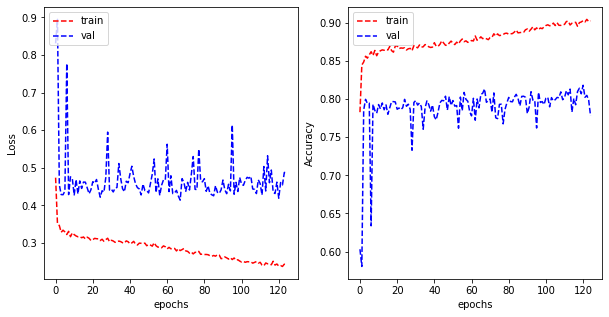

In [245]:
parameters["hidden_layer_dim"] = 256

layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"] / 4, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "MLP_6_CT",
                    lambda: train_save(train_set_ic, validation_set_ic, test_set_ic, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

### 3.1.2 VGG Net

#### Model 1

~~~~~~~~~~ H108_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E50_B32_IC_VGG_1 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 27)        756       
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 27)        108       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 27)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 27)          108       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 54)          13176

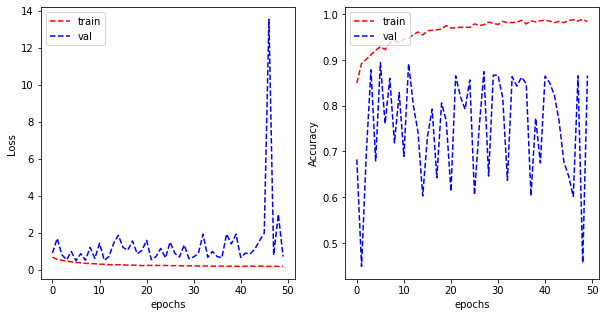

In [246]:
parameters["hidden_layer_dim"] = 108
parameters["epochs"] = 50
reg_lambda = 0.001

layers = [
    #VGG block 1
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.BatchNormalization(),
    
    #VGG block 2
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "IC_VGG_1",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 2

~~~~~~~~~~ H108_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E50_B32_IC_VGG_2 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 27)        756       
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 27)        108       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 27)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 9, 27)          108       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 54)          13176

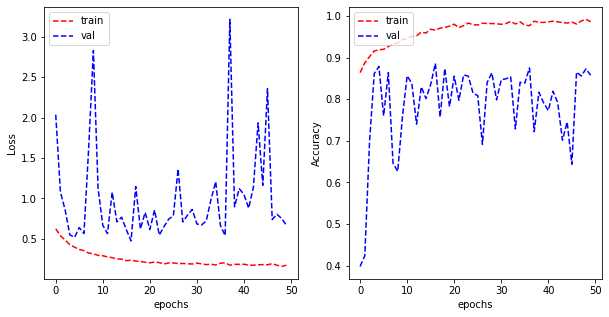

In [247]:
parameters["hidden_layer_dim"] = 108
parameters["epochs"] = 50
reg_lambda = 0.001

layers = [
    #VGG block 1
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.BatchNormalization(),
    
    #VGG block 2
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "IC_VGG_2",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'isCancerous'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

## 3.2 Cell Type Classification

In [248]:
# Initial hyperparameters.
parameters = {
    "hidden_layer_dim": 256,
    "optimizer": 'adam',
    "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    "metrics": 'categorical_accuracy',
    "epochs": 125,
    "batch_size": 32
}

In [249]:
OUTPUT_CLASSES_CELL_TYPE = 4

### 3.2.1 - MLP

#### Model 1

~~~~~~~~~~ H256_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_CELL_MLP_1 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


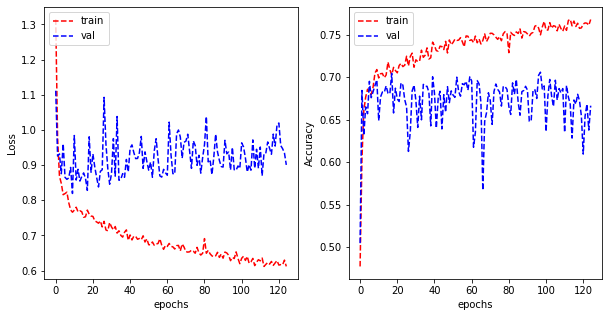

In [250]:
layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "CELL_MLP_1",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 2

~~~~~~~~~~ H128_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_CELL_MLP_2 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 128)               280064    
_________________________________________________________________
dense_86 (Dense)             (None, 4)                 516       
Total params: 280,580
Trainable params: 280,580
Non-trainable params: 0
_________________________________________________________________


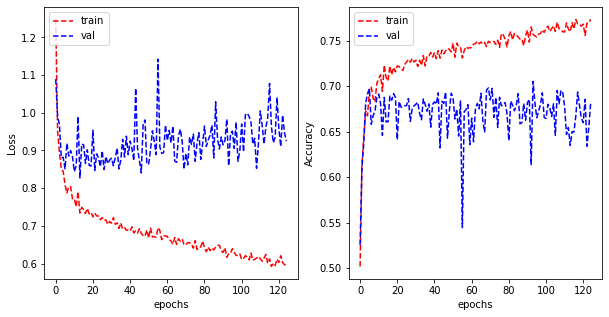

In [251]:
parameters["hidden_layer_dim"] = 128

layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "CELL_MLP_2",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 3

~~~~~~~~~~ H128_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_CELL_MLP_3 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_44 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_109 (Dense)            (None, 128)               280064    
_________________________________________________________________
dense_110 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_111 (Dense)            (None, 4)                 516       
Total params: 297,092
Trainable params: 297,092
Non-trainable params: 0
_________________________________________________________________
Found 5483 validated image filenames belonging to 4 classes.
Found 2231 validated image filenames belonging to 4 clas

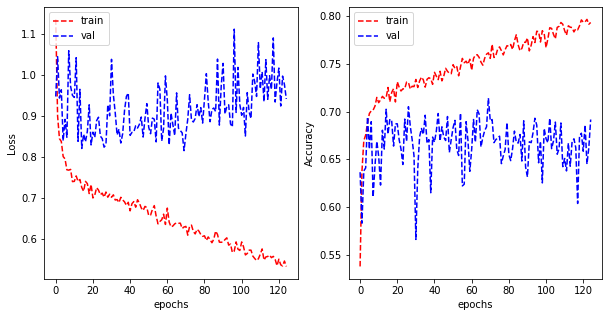

In [252]:
parameters["hidden_layer_dim"] = 128

layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "CELL_MLP_3",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 4

~~~~~~~~~~ H128_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_CELL_MLP_4 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_45 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_112 (Dense)            (None, 128)               280064    
_________________________________________________________________
dense_113 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_114 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_115 (Dense)            (None, 4)                 260       
Total params: 305,092
Trainable params: 305,092
Non-trainable params: 0
___________________________________________________

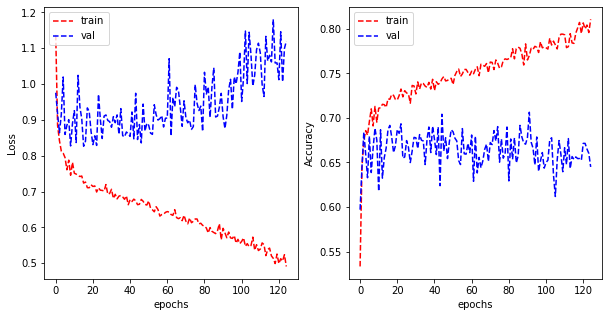

In [253]:
parameters["hidden_layer_dim"] = 128

layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"]/2, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "CELL_MLP_4",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 5

~~~~~~~~~~ H256_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E125_B32_CELL_MLP_5 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_46 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_116 (Dense)            (None, 256)               560128    
_________________________________________________________________
dense_117 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_118 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_119 (Dense)            (None, 4)                 260       
Total params: 601,540
Trainable params: 601,540
Non-trainable params: 0
___________________________________________________

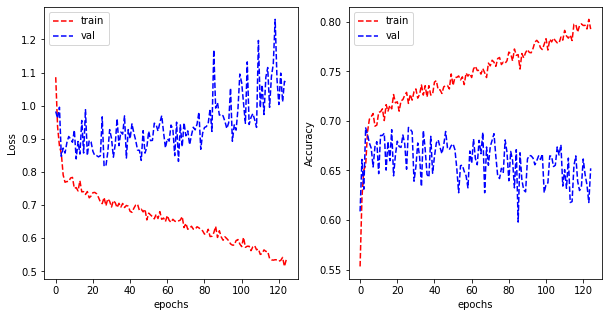

In [254]:
parameters["hidden_layer_dim"] = 256

layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"]/2, activation='relu'),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"]/4, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "CELL_MLP_5",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

### 3.2.2 VGG Net

#### Model 1

~~~~~~~~~~ H108_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E25_B32_VGG_1 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 27, 27, 27)        756       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 27)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 54)          13176     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 9, 54)          26298     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 54)          0       

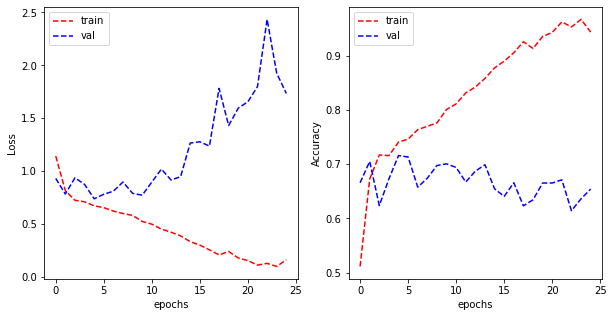

In [255]:
parameters["hidden_layer_dim"] = 108
parameters["epochs"] = 25

layers = [
    #VGG block 1
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE),
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "VGG_1",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 2

~~~~~~~~~~ H108_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E25_B32_VGG_2 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 27, 27, 27)        756       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 27)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 54)          13176     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 9, 9, 54)          26298     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 54)          0       

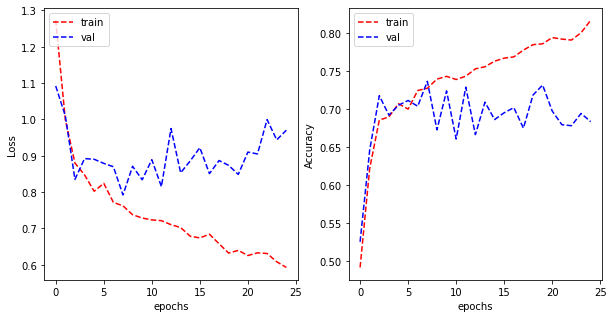

In [256]:
parameters["hidden_layer_dim"] = 108
parameters["epochs"] = 25
reg_lambda = 0.001

layers = [
    #VGG block 1
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE),
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "VGG_2",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Model 3

~~~~~~~~~~ H108_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E25_B32_VGG_3 ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 27, 27, 27)        756       
_________________________________________________________________
batch_normalization_12 (Batc (None, 27, 27, 27)        108       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 9, 27)          0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 9, 9, 27)          108       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 9, 54)          13176   

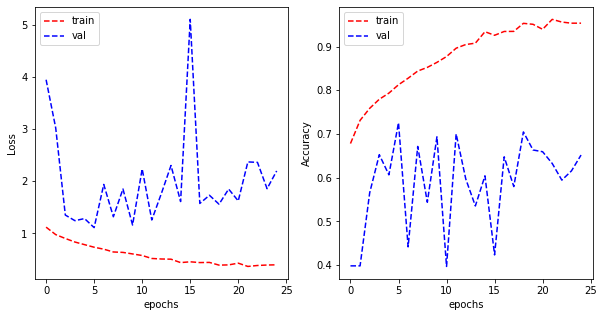

In [257]:
parameters["hidden_layer_dim"] = 108
parameters["epochs"] = 25
reg_lambda = 0.001

layers = [
    #VGG block 1
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/4, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.BatchNormalization(),
    
    #VGG block 2
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"]/2, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(parameters["hidden_layer_dim"], (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELL_TYPE),
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "VGG_3",
                    lambda: train_save(train_set_ct, validation_set_ct, test_set_ct, parameters, model, 'cellType'))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

# 4 - Ultimate Judgment

## 4.1 Cancerous Classification

### 4.1.1 MLP Final Model

In [258]:
# Final hyperparameters.
parameters = {
    "hidden_layer_dim": 50,
    "optimizer": 'adam',
    "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    "metrics": 'categorical_accuracy',
    "epochs": 5,
    "batch_size": 32
}

# The Deep Neural Network Layer Structure.
layers = [
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, "MLP",
                    lambda: train_save(train_set_ic, validation_set_ic, test_set_ic, parameters, model))

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

~~~~~~~~~~ H50_Oadam_Lcategoricalcrossentropy_Mcategoricalaccuracy_E5_B32_MLP ~~~~~~~~~~
/bin/bash: /: Is a directory
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_50 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_126 (Dense)            (None, 50)                109400    
_________________________________________________________________
dense_127 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 2)                 102       
Total params: 112,052
Trainable params: 112,052
Non-trainable params: 0
_____________________________________________________________

TypeError: ignored

### 4.1.2 VGG Net Final Model

In [ ]:
# Final hyperparameters.
parameters = {
    "hidden_layer_dim": 256,
    "optimizer": 'adam',
    "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    "metrics": 'categorical_accuracy',
    "epochs": 100,
    "batch_size": 32
}


# tf.keras.applications.InceptionV3(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000,
#     classifier_activation='softmax'
# )

# The Deep Neural Network Layer Structure.
layers = [
   
   # TODO
]

# Create model.
model = tf.keras.Sequential(layers)

# Train and save model
history = run_model(model, parameters, layers, lambda: )

# Plot the results for run though of the data (epoch).
plot_learning_curve(history['loss'],
                    history['val_loss'],
                    history['categorical_accuracy'],
                    history['val_categorical_accuracy'],
                    metric_name='Accuracy')

## 4.2 Cell Type Classification

### 4.2.1 MDP Final Model

### 4.2.2 VGG Net Final Model

# 5 - Improving Ultimate Judgment with Extra Data Set

Investigate Other Techniques hopefully OP

**Explore** how the data in both tasks can be used to improve the cell-type classification